# Approach based on density maps generation

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
#from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
# Torchvision library
import torchvision
import torch.nn as nn
from tqdm import tqdm # plot progress bars
import numpy as np

import os
import pandas as pd
#from torchvision.io import read_image
from PIL import Image
import seaborn as sns
import torch.utils.data as data
import copy
import cv2

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data adquisition  definition of the Dataset class and Dataloader

In [20]:
class CustomImageDataset(Dataset):

    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir    = img_dir
        self.transform  = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path) # I load it as a PIL image so I can perform some transforms that are not available for tensors.
        label_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 2])
        label    = cv2.imread(label_path,flags=cv2.IMREAD_ANYDEPTH)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    

In [21]:
path = "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn_kenel_counting_dataset/corn_kenel_counting_dataset/"

dataset = "corn"

train_csv_path  = path + f"{dataset}_coco/{dataset}_kernel_train_labels.csv" 
train_data_path = path + f"{dataset}_coco/train_set" 

test_csv_path  = path + f"{dataset}_coco/{dataset}_kernel_test_labels.csv" 
test_data_path = path + f"{dataset}_coco/test_set"


In [22]:
### Define transforms
train_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Resize((224,224)),])

# The test dataset must remain as original as possible
test_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((224,224)),])

target_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((224,224)),]) 

In [23]:
### Define dataset
train_dataset = CustomImageDataset(train_csv_path, train_data_path,
                                   transform=train_transforms,
                                   target_transform = target_transform)

test_dataset = CustomImageDataset(test_csv_path, test_data_path,
                                  transform = test_transforms,
                                  target_transform = target_transform)

In [24]:
# Split train data into train and validation sets
# (10% of training set will be used as validation set)
num_train_examples = int(len(train_dataset) * 0.90)
num_valid_examples = len(train_dataset) - num_train_examples

print(f"Number of training examples: {num_train_examples}")

Number of training examples: 217


In [25]:
# Create 'Subset' objects
train_dataset, validation_dataset = data.random_split(train_dataset, [num_train_examples, num_valid_examples])

print(f"Number training examples: {len(train_dataset)}")
print(f"Number validation examples: {len(validation_dataset)}")
print(f"Number test examples: {len(test_dataset)}")

Number training examples: 217
Number validation examples: 25
Number test examples: 62


In [26]:
# Apply test transformations to the validation set
validation_dataset = copy.deepcopy(validation_dataset) # If we change train transformations, this won't affect the validation set
validation_dataset.dataset.transform = test_transforms

In [27]:
# data Loaders
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)


Lets check if dataloaders are working properly

Feature batch shape: torch.Size([50, 3, 224, 224])
Labels batch shape: torch.Size([50, 1, 224, 224])


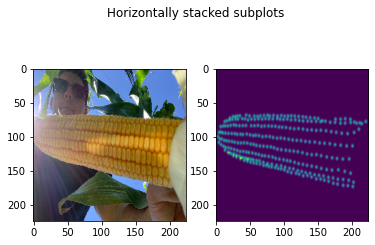

In [30]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].numpy().transpose(1, 2, 0)
label = train_labels[0].numpy().transpose(1, 2, 0)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.imshow(img)
ax2.imshow(label)
plt.show()

# Network architecture

In [ ]:
class Map_CNN(nn.Module):
    def __init__(self, Pre_Trained_Encoder):
        super().__init__()
        
        self.encoder     = Pre_Trained_Encoder
        self.regressor    = nn.Sequential(    
                            nn.Flatten(),            # Flatten layer
                            nn.Linear(in_features= ((512) * 7* 7),
                                      out_features=256),
                            nn.ReLU(True),
                            nn.Dropout(0.2),
                            nn.Linear(in_features= 256,
                                      out_features=128),
                            nn.ReLU(True),
                            nn.Dropout(0.2),
                            nn.Linear(in_features= 128,
                                      out_features=64),
                            nn.ReLU(True), 
                            nn.Dropout(0.2),
                            nn.Linear(in_features=64, out_features=1,bias=False) # Second linear layer
                        )
        
    def forward(self, x,mode):
        if (mode == "Train"):
            self.features.train()
            self.regressor.train()
        elif (mode == "Test"):
            self.features.eval()
            self.regressor.eval()
        y = self.features(x)
        y = self.regressor(y)
        return y

In [35]:
VGG16 = torchvision.models.vgg16(pretrained = False)

In [36]:
VGG16.load_state_dict(torch.load('C:/Users/hilar/.cache/torch/hub/checkpoints/vgg16-397923af.pth'))

<All keys matched successfully>

In [47]:
VGG16.features[0:20]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [43]:
result = VGG16.features[0:20](train_features)

In [44]:
result.shape

torch.Size([50, 512, 28, 28])

In [45]:
train_features.shape

torch.Size([50, 3, 224, 224])

In [31]:
mobilenet = torchvision.models.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\hilar/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:09<00:00, 1.48MB/s]


In [34]:
print(mobilenet.features)

Sequential(
  (0): ConvNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Re

In [79]:
#####################################################################
#####################################################################
# keep this to upsample the images and get the right count
# for this to work we need the original image size
# which is not simple to pass but ill need it for the final count only

label = train_labels[0]
print(label.size())
# I need to add a dummy axis simulating the minibatch dimension
label = label[None, :]
print(label.size())

# Upsample to the right dimension
m = nn.Upsample(size=(1280,1920),mode='bilinear')
label_2 = m(label)
print(label_2.size())

torch.Size([1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 1280, 1920])


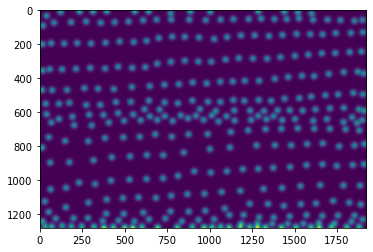

In [80]:
plt.imshow(label_2[0].numpy().transpose(1, 2, 0))

In [81]:
np.sum(label_2[0].numpy())

340.00116